# Creating `H3-tiles`

Most [tiled web maps](https://en.wikipedia.org/wiki/Tiled_web_map) follow certain Google Maps conventions:

- Tiles are 256x256 pixels
- At the outer most zoom level, 0, the entire world can be rendered in a single map tile.
- Each zoom level doubles in both dimensions, so a single tile is replaced by 4 tiles when zooming in. 
- The [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) projection is used, with latitude limits of around 85 degrees.

OpenStreetMap, Google Maps, MapBox, etc. use the standard known as [Slippy Map Tilenames](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames) or XYZ:

- Tiles are 256 × 256 pixel PNG files
- Each zoom level (z) is a directory, each column (x) is a subdirectory, and each tile (y) in that column is a file
- Filename (url) format is `http://.../z/x/y.png`

The conversion between tiles and coordinates has been described [here](https://www.maptiler.com/google-maps-coordinates-tile-bounds-projection/) ([source code](https://gist.github.com/maptiler/fddb5ce33ba995d5523de9afdf8ef118#file-globalmaptiles-py)). 

On the other hand, [H3](https://h3geo.org/) is a geospatial indexing system that partitions the world into hexagonal cells. H3 is a hierarchical geospatial index. H3 indexes refer to cells by the spatial hierarchy. Every hexagonal cell, up to the maximum resolution supported by H3, has seven child cells below it in this hierarchy. This subdivision is referred to as aperture 7. 

H3 enables the user to subdivide areas into smaller and smaller hexagons. H3 supports sixteen resolutions. Each finer resolution has cells with one seventh the area of the coarser resolution. We have to keep in mind that the zoom level and the resolution are different things.

In this notbook we will find the conversion between tiles and H3 hexagonal cells.

In [1]:
!pip install h3

## Import libraries

In [2]:
import h3
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt

## Tile coordinates for each zoom level

In [3]:
import math

class GlobalMercator(object):
    """
    TMS Global Mercator Profile
    ---------------------------
    Functions necessary for generation of tiles in Spherical Mercator projection,
    EPSG:900913 (EPSG:gOOglE, Google Maps Global Mercator), EPSG:3785, OSGEO:41001.
    Such tiles are compatible with Google Maps, Microsoft Virtual Earth, Yahoo Maps,
    UK Ordnance Survey OpenSpace API, ...
    and you can overlay them on top of base maps of those web mapping applications.
    
    Pixel and tile coordinates are in TMS notation (origin [0,0] in bottom-left).
    What coordinate conversions do we need for TMS Global Mercator tiles::
         LatLon      <->       Meters      <->     Pixels    <->       Tile     
     WGS84 coordinates   Spherical Mercator  Pixels in pyramid  Tiles in pyramid
         lat/lon            XY in metres     XY pixels Z zoom      XYZ from TMS 
        EPSG:4326           EPSG:900913                                         
         .----.              ---------               --                TMS      
        /      \     <->     |       |     <->     /----/    <->      Google    
        \      /             |       |           /--------/          QuadTree   
         -----               ---------         /------------/                   
       KML, public         WebMapService         Web Clients      TileMapService
    What is the coordinate extent of Earth in EPSG:900913?
      [-20037508.342789244, -20037508.342789244, 20037508.342789244, 20037508.342789244]
      Constant 20037508.342789244 comes from the circumference of the Earth in meters,
      which is 40 thousand kilometers, the coordinate origin is in the middle of extent.
      In fact you can calculate the constant as: 2 * math.pi * 6378137 / 2.0
      $ echo 180 85 | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:900913
      Polar areas with abs(latitude) bigger then 85.05112878 are clipped off.
    What are zoom level constants (pixels/meter) for pyramid with EPSG:900913?
      whole region is on top of pyramid (zoom=0) covered by 256x256 pixels tile,
      every lower zoom level resolution is always divided by two
      initialResolution = 20037508.342789244 * 2 / 256 = 156543.03392804062
    What is the difference between TMS and Google Maps/QuadTree tile name convention?
      The tile raster itself is the same (equal extent, projection, pixel size),
      there is just different identification of the same raster tile.
      Tiles in TMS are counted from [0,0] in the bottom-left corner, id is XYZ.
      Google placed the origin [0,0] to the top-left corner, reference is XYZ.
      Microsoft is referencing tiles by a QuadTree name, defined on the website:
      http://msdn2.microsoft.com/en-us/library/bb259689.aspx
    The lat/lon coordinates are using WGS84 datum, yeh?
      Yes, all lat/lon we are mentioning should use WGS84 Geodetic Datum.
      Well, the web clients like Google Maps are projecting those coordinates by
      Spherical Mercator, so in fact lat/lon coordinates on sphere are treated as if
      the were on the WGS84 ellipsoid.
     
      From MSDN documentation:
      To simplify the calculations, we use the spherical form of projection, not
      the ellipsoidal form. Since the projection is used only for map display,
      and not for displaying numeric coordinates, we don't need the extra precision
      of an ellipsoidal projection. The spherical projection causes approximately
      0.33 percent scale distortion in the Y direction, which is not visually noticable.
    How do I create a raster in EPSG:900913 and convert coordinates with PROJ.4?
      You can use standard GIS tools like gdalwarp, cs2cs or gdaltransform.
      All of the tools supports -t_srs 'epsg:900913'.
      For other GIS programs check the exact definition of the projection:
      More info at http://spatialreference.org/ref/user/google-projection/
      The same projection is degined as EPSG:3785. WKT definition is in the official
      EPSG database.
      Proj4 Text:
        +proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0
        +k=1.0 +units=m +nadgrids=@null +no_defs
      Human readable WKT format of EPGS:900913:
         PROJCS["Google Maps Global Mercator",
             GEOGCS["WGS 84",
                 DATUM["WGS_1984",
                     SPHEROID["WGS 84",6378137,298.2572235630016,
                         AUTHORITY["EPSG","7030"]],
                     AUTHORITY["EPSG","6326"]],
                 PRIMEM["Greenwich",0],
                 UNIT["degree",0.0174532925199433],
                 AUTHORITY["EPSG","4326"]],
             PROJECTION["Mercator_1SP"],
             PARAMETER["central_meridian",0],
             PARAMETER["scale_factor",1],
             PARAMETER["false_easting",0],
             PARAMETER["false_northing",0],
             UNIT["metre",1,
                 AUTHORITY["EPSG","9001"]]]
    """
    
    def __init__(self, tileSize=256):
        "Initialize the TMS Global Mercator pyramid"
        self.tileSize = tileSize
        self.initialResolution = 2 * math.pi * 6378137 / self.tileSize
        # 156543.03392804062 for tileSize 256 pixels
        self.originShift = 2 * math.pi * 6378137 / 2.0
        # 20037508.342789244
        
    def MetersToLatLon(self, mx, my ):
        "Converts XY point from Spherical Mercator EPSG:900913 to lat/lon in WGS84 Datum"

        lon = (mx / self.originShift) * 180.0
        lat = (my / self.originShift) * 180.0

        lat = 180 / math.pi * (2 * math.atan( math.exp( lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    def Resolution(self, zoom ):
        "Resolution (meters/pixel) for given zoom level (measured at Equator)"
        
        # return (2 * math.pi * 6378137) / (self.tileSize * 2**zoom)
        return self.initialResolution / (2**zoom)
        
    def PixelsToMeters(self, px, py, zoom):
        "Converts pixel coordinates in given zoom level of pyramid to EPSG:900913"

        res = self.Resolution( zoom )
        mx = px * res - self.originShift
        my = py * res - self.originShift
        return mx, my
        

    def TileBounds(self, tx, ty, zoom):
        "Returns bounds of the given tile in EPSG:900913 coordinates"
        
        minx, miny = self.PixelsToMeters( tx*self.tileSize, ty*self.tileSize, zoom )
        maxx, maxy = self.PixelsToMeters( (tx+1)*self.tileSize, (ty+1)*self.tileSize, zoom )
        return ( minx, miny, maxx, maxy )
        
    def TileLonLatBounds(self, tx, ty, zoom ):
        "Returns bounds of the given tile in latutude/longitude using WGS84 datum"

        bounds = self.TileBounds( tx, ty, zoom)
        minLat, minLon = self.MetersToLatLon(bounds[0], bounds[1])
        maxLat, maxLon = self.MetersToLatLon(bounds[2], bounds[3])
         
        return ( minLon, minLat, maxLon, maxLat )
    
    def GoogleTile(self, tx, ty, zoom):
        "Converts TMS tile coordinates to Google Tile coordinates and vice versa"
        
        # coordinate origin is moved from bottom-left to top-left corner of the extent
        return tx, (2**zoom - 1) - ty

In [4]:
def TileCoordinates (z):
    """Tile coordinates for a given z"""
    return np.arange(int(np.sqrt(4**z)))

In [5]:
def TileBbox(minZ, maxZ):
    """Tile bounding boxes for a given range of zoom levels"""
    gdf = gpd.GeoDataFrame(columns=['z', 'x', 'y','bbox'])
    bboxes = []
    Z = []
    X = []
    Y = []
    
    ## Get bounding box
    zVals = np.arange(minZ,maxZ+1)
    for z in zVals:
        xVals = TileCoordinates(z)
        yVals = TileCoordinates(z)
        for x in xVals:
            for y in yVals:
                # Get bounding box
                x_TMS, y_TMS = GM.GoogleTile(x,y,z)
                bbox = list(GM.TileLonLatBounds(x_TMS,y_TMS,z))
                Z.append(z)
                X.append(x)
                Y.append(y)
        
                # Replace 180.0 with 179.99
                bbox = [x if x != 180.0 else 179.99 for x in bbox]
                bbox = [x if x != -180.0 else -179.99 for x in bbox]
                
                bboxes.append(bbox)
                
    gdf['z'] = Z
    gdf['x'] = X
    gdf['y'] = Y
    gdf['bbox'] = bboxes
    
    gdf['geometry'] = gdf['bbox'].apply(lambda x: geometry.box(x[0], x[1], x[2], x[3]))
    
    gdf.crs = "EPSG:4326"
       
    return gdf

In [6]:
GM = GlobalMercator()

In [7]:
tiles = TileBbox(0, 3)
tiles

,z,x,y,bbox,geometry
0,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.99000 -85.05113, 179.99000 85.05..."
1,1,0,0,"[-179.99, 0.0, 0.0, 85.0511287798066]","POLYGON ((0.00000 0.00000, 0.00000 85.05113, -..."
2,1,0,1,"[-179.99, -85.05112877980659, 0.0, 0.0]","POLYGON ((0.00000 -85.05113, 0.00000 0.00000, ..."
3,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((179.99000 0.00000, 179.99000 85.0511..."
4,1,1,1,"[0.0, -85.05112877980659, 179.99, 0.0]","POLYGON ((179.99000 -85.05113, 179.99000 0.000..."
...,...,...,...,...,...
80,3,7,3,"[135.00000000000003, 0.0, 179.99, 40.979898069...","POLYGON ((179.99000 0.00000, 179.99000 40.9799..."
81,3,7,4,"[135.00000000000003, -40.97989806962014, 179.9...","POLYGON ((179.99000 -40.97990, 179.99000 0.000..."
82,3,7,5,"[135.00000000000003, -66.51326044311185, 179.9...","POLYGON ((179.99000 -66.51326, 179.99000 -40.9..."
83,3,7,6,"[135.00000000000003, -79.17133464081945, 179.9...","POLYGON ((179.99000 -79.17133, 179.99000 -66.5..."


**Display tiles**

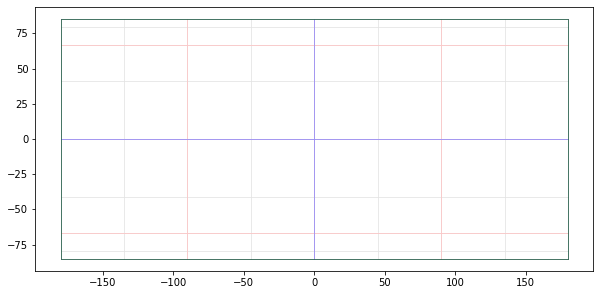

In [8]:
colors = ['k', 'r', 'b', 'g']
fig, ax = plt.subplots(figsize=(10,10))
for n, z in enumerate(tiles['z'].unique()[::-1]):
    tiles[tiles['z'] == z].plot(ax=ax, color='w', edgecolor=colors[n], alpha=0.5)

## Convert bounding boxes to H3 hexagons

For convenience, you can use [H3-Pandas](https://github.com/DahnJ/H3-Pandas).

In [9]:
!pip install h3pandas

In [10]:
import h3pandas

We will use the following H3 resolutions for each zoom levels. See the [H3 resolution](https://h3geo.org/docs/core-library/restable/) table for more details.

In [23]:
z_res = {'0':3, '1':3, '2':3, '3':4}

We can add H3 hexagons using the function [`polyfill`](https://h3-pandas.readthedocs.io/en/latest/h3pandas.html#h3pandas.h3pandas.H3Accessor.polyfill). This method adds a list of H3 cells whose centroid falls into each polygon. If we want to explode the values horizontally (ending up with as many rows as there are H3 cells), we can use the parameter explode

In [24]:
tiles_h3 = gpd.GeoDataFrame(columns=['z', 'x', 'y', 'bbox', 'geometry', 'h3_polyfill', 'resolution'])
for n,z in enumerate(tiles['z'].unique()):
    gdf = tiles[tiles['z'] == z]
    gdf_h3 = gdf.h3.polyfill(z_res[str(z)], explode=True)
    gdf_h3['resolution'] = z_res[str(z)]
    
    tiles_h3 = pd.concat([tiles_h3, gdf_h3])

In [37]:
tiles_h3

,z,x,y,bbox,geometry,h3_polyfill,resolution
0,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.99000 -85.05113, 179.99000 85.05...",833296fffffffff,3
0,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.99000 -85.05113, 179.99000 85.05...",839a59fffffffff,3
0,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.99000 -85.05113, 179.99000 85.05...",8371b2fffffffff,3
0,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.99000 -85.05113, 179.99000 85.05...",837192fffffffff,3
0,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.99000 -85.05113, 179.99000 85.05...",83eab1fffffffff,3
...,...,...,...,...,...,...,...
84,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((179.99000 -85.05113, 179.99000 -79.1...",84f3b19ffffffff,4
84,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((179.99000 -85.05113, 179.99000 -79.1...",84f3803ffffffff,4
84,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((179.99000 -85.05113, 179.99000 -79.1...",84f2b49ffffffff,4
84,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((179.99000 -85.05113, 179.99000 -79.1...",84f39c5ffffffff,4


We can then utilize the method `h3_to_geo_boundary` to obtain the geometries for the H3 cells. It expects that the index already has the H3 cell ids.

In [38]:
tiles_h3 = tiles_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()

In [39]:
tiles_h3

,z,x,y,bbox,geometry,resolution
h3_polyfill,,,,,,
833296fffffffff,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((-179.30190 42.68315, -179.17011 43.3...",3
839a59fffffffff,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((-179.73339 -8.69902, -179.44307 -8.1...",3
8371b2fffffffff,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((-179.57460 7.31741, -179.46589 7.891...",3
837192fffffffff,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((179.60705 5.46999, 179.50378 4.91008...",3
83eab1fffffffff,0,0,0,"[-179.99, -85.05112877980659, 179.99, 85.05112...","POLYGON ((-178.88067 -61.32933, -179.43212 -60...",3
...,...,...,...,...,...,...
84f3b19ffffffff,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((166.14231 -79.19247, 165.33726 -79.3...",4
84f3803ffffffff,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((175.26076 -80.94851, 174.47675 -81.1...",4
84f2b49ffffffff,3,7,7,"[135.00000000000003, -85.05112877980659, 179.9...","POLYGON ((166.53492 -84.80588, 164.77984 -84.9...",4


In [46]:
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x) & (tiles_h3['y'] == y)]

,z,x,y,bbox,geometry,resolution
h3_polyfill,,,,,,
831f88fffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((10.15318 47.72409, 10.21749 47.12772...",3
830a8afffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((103.54033 58.98834, 104.57619 58.653...",3
837314fffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((129.32602 9.56087, 129.44298 8.90227...",3
833d96fffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((74.72785 22.92782, 75.01089 22.41057...",3
8353a0fffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((34.95350 23.55219, 34.85650 22.89195...",3
...,...,...,...,...,...,...
83158afffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((121.14987 50.77705, 121.79343 50.349...",3
831e31fffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((14.92208 49.83122, 14.95089 49.24329...",3
833c1afffffffff,1,1,0,"[0.0, 0.0, 179.99, 85.0511287798066]","POLYGON ((87.90781 24.88419, 87.70825 25.48113...",3


**Display 4 contiguous tiles**

In [73]:
z = 2; x = 1; y=1

In [71]:
z = 3; x = 2; y=2

<AxesSubplot:>

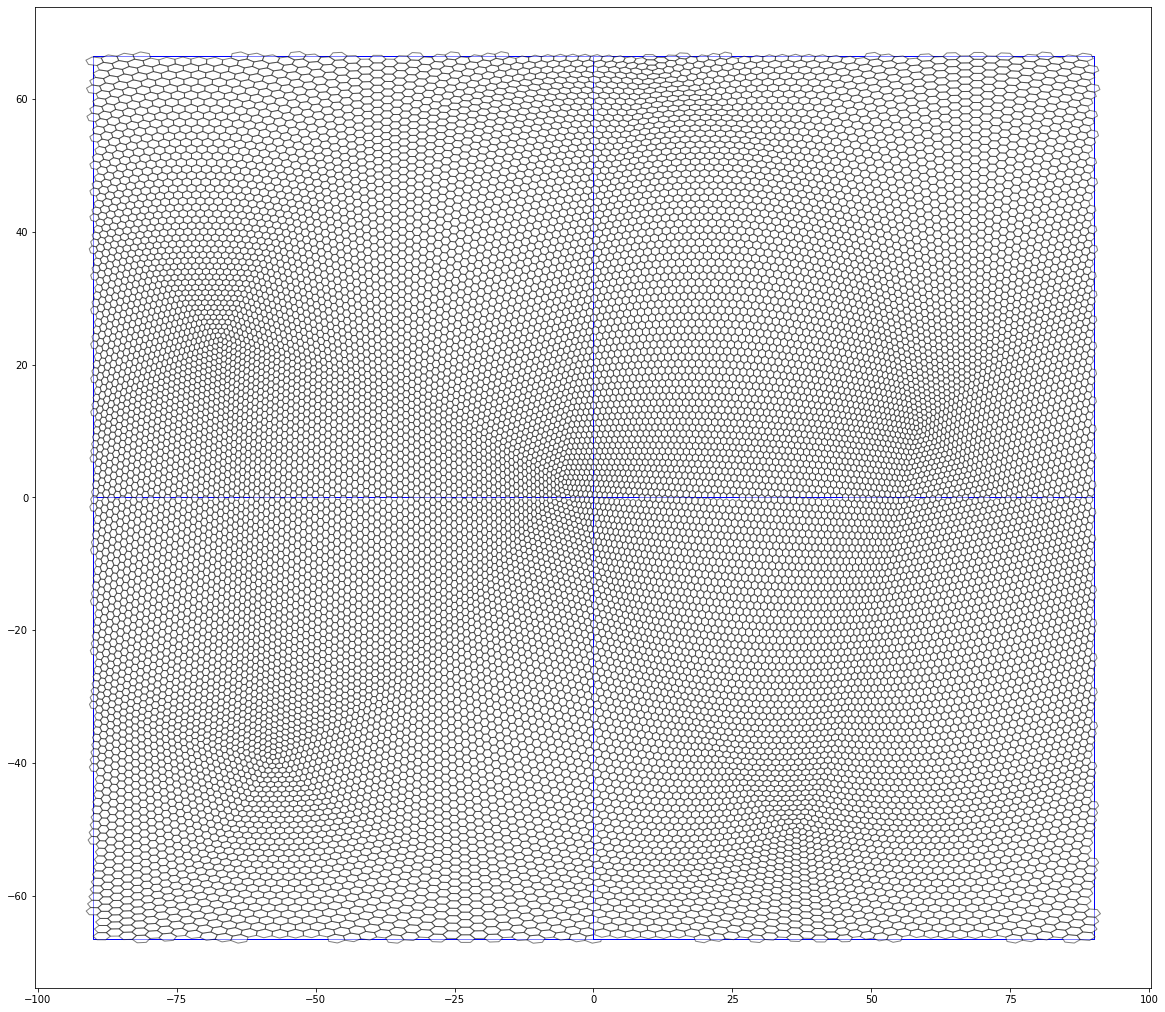

In [74]:
fig, ax = plt.subplots(figsize=(20,20))

tiles[(tiles['z'] == z) & (tiles['x'] == x) & (tiles['y'] == y)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x) & (tiles_h3['y'] == y)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

tiles[(tiles['z'] == z) & (tiles['x'] == x) & (tiles['y'] == y+1)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x) & (tiles_h3['y'] == y+1)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

tiles[(tiles['z'] == z) & (tiles['x'] == x+1) & (tiles['y'] == y)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x+1) & (tiles_h3['y'] == y)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)

tiles[(tiles['z'] == z) & (tiles['x'] == x+1) & (tiles['y'] == y+1)].plot(ax=ax, color='w', edgecolor='b')
tiles_h3[(tiles_h3['z'] == z) & (tiles_h3['x'] == x+1) & (tiles_h3['y'] == y+1)].plot(ax=ax, color='w', edgecolor='k', alpha=0.5)